In [1]:
import csv
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding,SimpleRNN,GRU
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('russian'))
from string import punctuation
punct = list(punctuation)
from tqdm import tqdm
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a.n.piskunov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv(r'C:\Users\a.n.piskunov\Downloads\for-teams\payments_training.tsv', sep='\t', names=['date', 'price', 'text', 'category'])

In [3]:
data.head()

,date,price,text,category
1,07.11.2024,15300.00,За участие в конференции в г. Майкоп по догово...,SERVICE
2,07.11.2024,"40200,00",За оказание услуг по договору №79-02726В от 01...,SERVICE
3,07.11.2024,1440-00,Оплата за Порошок стиральный Ariel Color autom...,NON_FOOD_GOODS
4,07.11.2024,240000000-00,Возврат денежных средств по договору займа №04...,LOAN
5,07.11.2024,1360000.00,"Оплата Дог №452 от 13/03/2021, согл. Сч 0745-2...",NOT_CLASSIFIED


In [4]:
articles=data['text'].to_list()
labels=data['category'].to_list()

In [5]:
only_text_regex = r'[^а-яА-ЯёЁ]+'
stop_words = set(stopwords.words('russian'))


def clean_text(text):
    text = re.sub(only_text_regex, ' ', text)
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    
    return text

In [6]:
for i in tqdm(range(len(articles))):
    articles[i]=clean_text(articles[i])
articles

100%|████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 206311.07it/s]


['участие конференции г Майкоп договору ДВ апреля',
 'оказание услуг договору г',
 'Оплата Порошок стиральный кг счету августа г Сумма',
 'Возврат денежных средств договору займа НДС',
 'Оплата Дог согл Сч г оплата сброс загрязняющих веществ',
 'Оплата дог финансовой аренды Б г акт приема передачи г т ч НДС',
 'Оплата Мицеллярная вода Чистая Линия Цветочная типов кожи мл счету мая г Сумма',
 'Оплата Стиральные порошки счету г Сумма',
 'Оплата договору Е августа г счету августа г мясные деликатесы Сумма т ч НДС',
 'Оплата договору процентного займа б н г НДС',
 'Оплата договору процентного займа Б г НДС',
 'Предоставление кредита договору г приобретение недвижимости',
 'тур поездку договору Д сентября',
 'гостиницу Россия г Королёв',
 'Оплата договору процентного займа Г НДС',
 'Лечение договору Е',
 'Оплата Хлопья овсяные Ясно Солнышко г счету Сумма',
 'Предоплата автозапчасти счету г года Договор АБ октября г',
 'Оплата гос пошлины',
 'Оплата Суперклей Универсал г счету Сумма',
 'Коми

In [7]:
vocab_size =5000
embedding_dim =64
max_length =200
oov_tok = '<OOV>' 
training_portion = 0.8

In [8]:
train_size = int(len(articles) * training_portion)
train_articles = articles[0: train_size]
train_labels = labels[0: train_size]
validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

In [9]:
print('train_articles' ,len(train_articles))
print('train_labels', len(train_labels))
print('validation_articles', len(validation_articles))
print('validation_labels', len(validation_labels))

train_articles 400
train_labels 400
validation_articles 100
validation_labels 100


In [10]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

In [11]:
word_index

{'г': 1,
 'оплата': 2,
 'счету': 3,
 'договору': 4,
 'сумма': 5,
 'ндс': 6,
 'т': 7,
 'ч': 8,
 'займа': 9,
 'д': 10,
 'комиссия': 11,
 'б': 12,
 'дог': 13,
 'средств': 14,
 'е': 15,
 'приема': 16,
 'передачи': 17,
 'процентного': 18,
 'услуг': 19,
 'мл': 20,
 'лизинга': 21,
 'договор': 22,
 'банк': 23,
 'сч': 24,
 'акт': 25,
 'оказание': 26,
 'возврат': 27,
 'денежных': 28,
 'услуги': 29,
 'мая': 30,
 'гос': 31,
 'адресу': 32,
 'облагается': 33,
 'учета': 34,
 'марта': 35,
 'финансовой': 36,
 'аренды': 37,
 'пошлины': 38,
 'счет': 39,
 'января': 40,
 'ул': 41,
 'ноября': 42,
 'оао': 43,
 'второй': 44,
 'сентября': 45,
 'пошлина': 46,
 'справку': 47,
 'письменному': 48,
 'запросу': 49,
 'клиента': 50,
 'обслуживание': 51,
 'ассортименте': 52,
 'процентов': 53,
 'долевое': 54,
 'инвестирование': 55,
 'жилищное': 56,
 'строительство': 57,
 'июля': 58,
 'помещения': 59,
 'счета': 60,
 'апреля': 61,
 'согл': 62,
 'предоплата': 63,
 'государственная': 64,
 'прочих': 65,
 'покупка': 66,
 'тов

In [12]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
len(train_sequences)

400

In [13]:
train_padded = pad_sequences(train_sequences, maxlen=max_length)

In [14]:
len(train_padded),len(train_padded[0])

(400, 200)

In [15]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length)

In [16]:
dict_={}
for i,x in tqdm(enumerate(set(labels))):
    dict_[x]=i
dict_

9it [00:00, ?it/s]


{'SERVICE': 0,
 'FOOD_GOODS': 1,
 'BANK_SERVICE': 2,
 'NON_FOOD_GOODS': 3,
 'LEASING': 4,
 'REALE_STATE': 5,
 'NOT_CLASSIFIED': 6,
 'TAX': 7,
 'LOAN': 8}

In [17]:
training_label_seq = np.array([dict_[train_labels[i]] for i in tqdm(range(len(train_labels)))])
validation_label_seq = np.array([dict_[np.array(validation_labels)[i]] for i in tqdm(range(len(validation_labels)))])


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 33732.54it/s]


In [18]:
train_labels[0], training_label_seq[0]


('SERVICE', 0)

In [19]:
pd.DataFrame(training_label_seq).value_counts()


3    82
1    74
0    65
2    38
7    33
8    33
4    31
5    23
6    21
dtype: int64

In [20]:
pd.DataFrame(validation_label_seq).value_counts()


0    23
1    16
7    15
3    14
2    11
8     8
4     7
5     4
6     2
dtype: int64

Text(0, 0.5, 'Count')

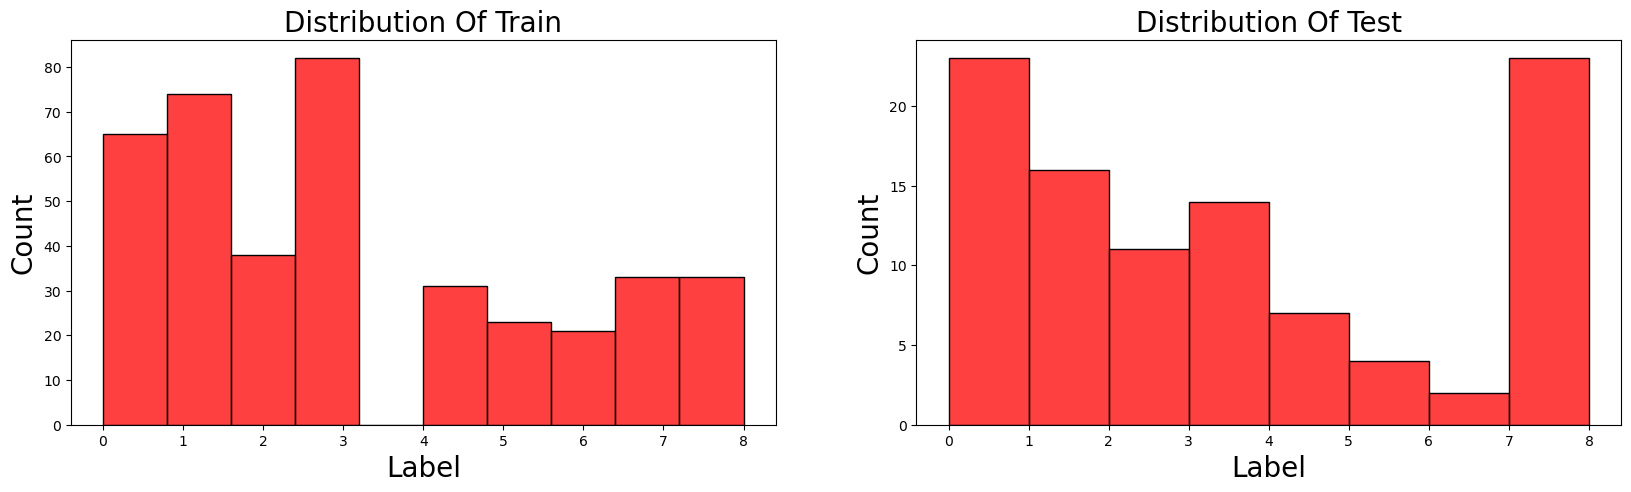

In [21]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title("Distribution Of Train",fontsize=20)
sns.histplot(training_label_seq,color='red')
plt.xlabel('Label',fontsize=20)
plt.ylabel("Count",fontsize=20)
plt.subplot(1,2,2)
plt.title("Distribution Of Test",fontsize=20)
sns.histplot(validation_label_seq,color='red')
plt.xlabel('Label',fontsize=20)
plt.ylabel("Count",fontsize=20)

In [22]:
model = Sequential()
model.add(Embedding(vocab_size,embedding_dim))
model.add(Dropout(0.5))
model.add(GRU(units =32))
model.add(Dropout(0.5))
model.add(Dense(5,activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np

  
print("Train padded shape:", train_padded.shape) 
print("Training labels shape:", training_label_seq.shape)  
print("Unique labels in training data:", np.unique(training_label_seq))  

model = Sequential([
    Embedding(input_dim=20000, output_dim=100, input_length=200),
    Bidirectional(GRU(128)),  
    Dropout(0.3),
    Dense(9, activation='softmax')  
   ])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history = model.fit(train_padded, training_label_seq, epochs=50,
                       validation_data=(validation_padded, validation_label_seq),
                       callbacks=[reduce_lr, early_stop])
   

Train padded shape: (400, 200)
Training labels shape: (400,)
Unique labels in training data: [0 1 2 3 4 5 6 7 8]
Epoch 1/50


C:\ProgramData\Anaconda\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.1788 - loss: 2.1572 - val_accuracy: 0.1400 - val_loss: 2.0391 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.2217 - loss: 1.9899 - val_accuracy: 0.4100 - val_loss: 1.7727 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.3971 - loss: 1.6913 - val_accuracy: 0.5200 - val_loss: 1.3559 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.5290 - loss: 1.2738 - val_accuracy: 0.7600 - val_loss: 0.8697 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.7297 - loss: 0.8730 - val_accuracy: 0.8500 - val_loss: 0.5975 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.8173 - loss: 0.5685 - val_accuracy: 0.8800 - val_loss: 0.4275 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.8856 - loss: 0.4475 - val_accurac

In [24]:
pd.DataFrame(history.history)


,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.1975,2.122090,0.14,2.039081,0.0010
1,0.2725,1.952229,0.41,1.772688,0.0010
2,0.4150,1.620711,0.52,1.355894,0.0010
3,0.5575,1.171948,0.76,0.869687,0.0010
4,0.7150,0.842293,0.85,0.597468,0.0010
5,0.8075,0.580524,0.88,0.427463,0.0010
6,0.9175,0.384573,0.93,0.280396,0.0010
7,0.9650,0.200980,0.95,0.181050,0.0010
8,0.9750,0.131100,0.96,0.145940,0.0010
9,0.9975,0.069313,0.96,0.097257,0.0010


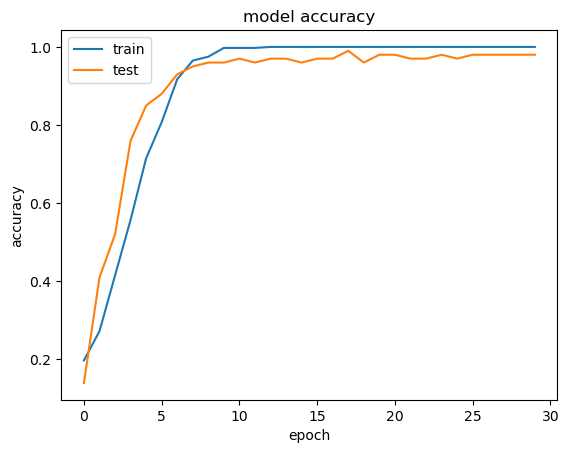

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

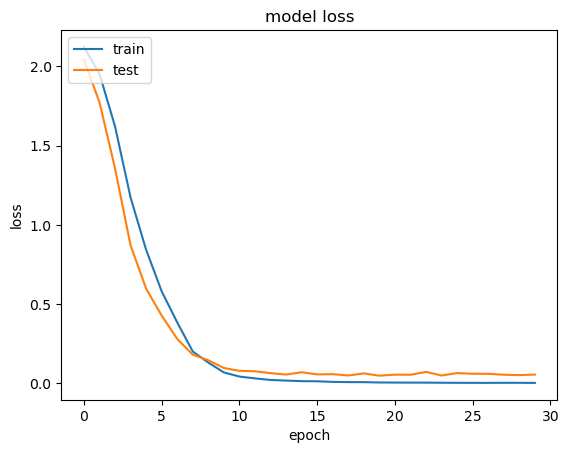

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
y_pred=model.predict(validation_padded)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


In [28]:
pred=[np.argmax(i) for i in tqdm(y_pred)]
df=pd.DataFrame()
df['Prediction'],df['actual']=pred,validation_label_seq
df

100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 100366.21it/s]


,Prediction,actual
0,0,0
1,7,7
2,0,0
3,3,3
4,4,4
...,...,...
95,7,7
96,2,2
97,0,0
98,1,1


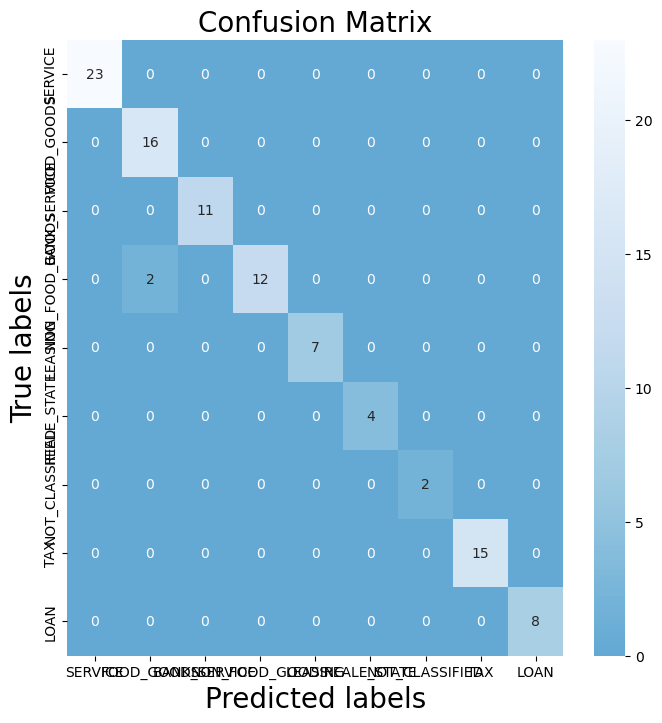

array([[23,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 16,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 11,  0,  0,  0,  0,  0,  0],
       [ 0,  2,  0, 12,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  7,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  4,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 15,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  8]], dtype=int64)

In [29]:
CM = confusion_matrix(validation_label_seq,pred)
plt.figure(figsize=(8,8))
ax= plt.subplot()
sns.heatmap(CM, center = True, fmt='g',ax=ax,annot=True,cmap='Blues_r')
ax.set_xlabel('Predicted labels',fontsize=20)
ax.set_ylabel('True labels',fontsize=20) 
ax.set_title('Confusion Matrix',fontsize=20)
ax.xaxis.set_ticklabels(dict_.keys()) 
ax.yaxis.set_ticklabels(dict_.keys())
plt.show()
CM

In [30]:
from sklearn.metrics import classification_report, roc_auc_score
from scipy import stats
import numpy as np


pred_prob = model.predict(validation_padded)


print("Predicted probabilities shape:", pred_prob.shape)


if len(pred_prob.shape) == 1:
    pred_prob = np.expand_dims(pred_prob, axis=1)  


if pred_prob.shape[1] == 1:
    pred_prob = np.hstack([1 - pred_prob, pred_prob]) 


pred_labels = np.argmax(pred_prob, axis=1) 


classification_report_result = classification_report(validation_label_seq, pred_labels)
print('Classification Report:n', classification_report_result)


roc_auc = roc_auc_score(validation_label_seq, pred_prob, multi_class='ovr')  
print('ROC AUC Score:', roc_auc)


gini_coefficient = 2 * roc_auc - 1
print('Gini Coefficient:', gini_coefficient)


ks_statistic, ks_p_value = stats.ks_2samp(pred_prob[validation_label_seq == 0][:, 1], 
                                           pred_prob[validation_label_seq == 1][:, 1])
print('Kolmogorov-Smirnov Statistic:', ks_statistic)
print('Kolmogorov-Smirnov p-value:', ks_p_value)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted probabilities shape: (100, 9)
Classification Report:n               precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       0.89      1.00      0.94        16
           2       1.00      1.00      1.00        11
           3       1.00      0.86      0.92        14
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00         8

    accuracy                           0.98       100
   macro avg       0.99      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100

ROC AUC Score: 0.9998346560846562
Gini Coefficient: 0.9996693121693123
Kolmogorov-Smirnov Statistic: 1.0
Kolmogorov-Smirnov p-value: 5.303455645597067e-11


In [31]:
def get_code(N):
    for x,y in dict_.items():
        if y==N:
            return x

In [32]:
txt = ['Оплата штрафа']


seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
print(pred)
print(np.argmax(pred))
print(get_code(np.argmax(pred)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[1.7655708e-02 1.0582657e-03 3.5104440e-05 3.4084602e-05 4.0045720e-06
  1.1448972e-04 7.5255930e-02 9.0575057e-01 9.1837377e-05]]
7
TAX


In [33]:
dff = pd.read_csv(r'C:\Users\a.n.piskunov\Downloads\for-teams\payments_main.tsv', sep='\t', names=['date', 'price', 'text'])   # Пример нескольких предложений
df = dff[:300]
df = df['text'].to_list()

In [34]:
dff.head()

,date,price,text
1,07.11.2024,40500.00,За тур.поездку по договору №001 от 27.01.2023г
2,07.11.2024,"32600,00",За оказание услуг по договору №53Б-02746 от 23...
3,07.11.2024,4710-00,Оплата штрафа
4,07.11.2024,30900-00,Лечение по договору №Д-00359/24 от 08.03.2025
5,07.11.2024,13200.00,Оплата основного долга за период с 16.12.2024г...


In [35]:


def get_code(N):
    for x, y in dict_.items():
        if y == N:
            return x


seq = tokenizer.texts_to_sequences(df)


padded = pad_sequences(seq, maxlen=max_length)


pred = model.predict(padded)


for i in range(len(pred)):
    print(f'Предложение: {df[i]}')
    print(f'Предсказание: {pred[i]}')
    print(f'Индекс класса: {np.argmax(pred[i])}')
    print(f'Код: {get_code(np.argmax(pred[i]))}n')


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Предложение: За тур.поездку по договору №001 от 27.01.2023г
Предсказание: [9.9325895e-01 2.0233108e-04 4.1578160e-06 1.9370304e-06 2.7110787e-07
 3.4170164e-04 3.7853580e-03 2.3935232e-03 1.1778767e-05]
Индекс класса: 0
Код: SERVICEn
Предложение: За оказание услуг по договору №53Б-02746 от 23/08/2024
Предсказание: [9.9938047e-01 1.1222227e-05 1.0830720e-06 2.9544444e-07 7.1430691e-08
 1.6410631e-04 3.9540284e-04 4.3018204e-05 4.2585989e-06]
Индекс класса: 0
Код: SERVICEn
Предложение: Оплата штрафа
Предсказание: [1.7655708e-02 1.0582657e-03 3.5104440e-05 3.4084602e-05 4.0045720e-06
 1.1448972e-04 7.5255930e-02 9.0575057e-01 9.1837377e-05]
Индекс класса: 7
Код: TAXn
Предложение: Лечение по договору №Д-00359/24 от 08.03.2025
Предсказание: [9.9574238e-01 8.1398030e-05 4.0707391e-06 1.2829690e-06 2.3884576e-07
 3.4139905e-04 3.1363363e-03 6.7811576e-04 1.4821928e-05]
Индекс класса: 0
Код: SERVICEn
Предложение: Оплата основного долга за период с 16.12.